# <p align="center">Siemens Sales Forecast</p>

---

## <p align="center">*2 - Feature Selection & Modeling*</p>

---

### 👥 **Team Members**
- **Ana Farinha** *(Student Number: 20211514)*  
- **António Oliveira** *(Student Number: 20211595)*  
- **Mariana Neto** *(Student Number: 20211527)*  
- **Salvador Domingues** *(Student Number: 20240597)*  

📅 **Date:** *April 1, 2025*  
📍 **Prepared for:** *Siemens*  

**GitHub Repo:** https://github.com/MGN19/Siemens-forecast

---

# ToC

<a class="anchor" id="top"></a>


1. [Import Libraries & Data](#1.-Import-Libraries-&-Data) <br><br>

2. [Product Category #1](#Product-Category-#1) <br><br>

In [1]:
## CELL TYPES (remover depois)

<div class="alert-danger">
    
test

<div class="alert-warning">
    
test

<div class="alert-info">
    
test

# 1. Import Libraries & Data

In [1]:
import os
import pandas as pd

pd.set_option('display.max_columns', None)

# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

import fs_modelling as m

**Data**

In [2]:
X_train = pd.read_csv('./data/X_train_data/X_train.csv', index_col = 'Unnamed: 0')
X_val = pd.read_csv('./data/X_val_data/X_val.csv', index_col = 'Unnamed: 0')

def import_all_csvs_as_vars(folder):
    for file in os.listdir(folder):
        if file.endswith('.csv'):
            df_name = file.replace('.csv', '')
            df = pd.read_csv(os.path.join(folder, file))
            globals()[df_name] = df
            # print(f"Loaded {df_name}")

# Import each CSV file as individual DataFrames
import_all_csvs_as_vars('data/y_train_data')
import_all_csvs_as_vars('data/y_val_data')

Loaded y_train_36
Loaded y_train_8
Loaded y_train_20
Loaded y_train_9
Loaded y_train_4
Loaded y_train_11
Loaded y_train_5
Loaded y_train_12
Loaded y_train_13
Loaded y_train_6
Loaded y_train_16
Loaded y_train_3
Loaded y_train_1
Loaded y_train_14
Loaded y_val_1
Loaded y_val_3
Loaded y_val_6
Loaded y_val_5
Loaded y_val_4
Loaded y_val_16
Loaded y_val_14
Loaded y_val_11
Loaded y_val_13
Loaded y_val_12
Loaded y_val_36
Loaded y_val_20
Loaded y_val_9
Loaded y_val_8


# Product Category #1

<a href="#top">Top &#129033;</a>

In [3]:
datasets = [X_train, X_val, y_train_1, y_val_1]

**Scaling**

In [4]:
X_train_scaled, X_val_scaled = m.scale_data(X_train, 
                                          X_val, 
                                          scaler_type='minmax')

## 2.1 Feature Selection

Selected 41 features by correlation


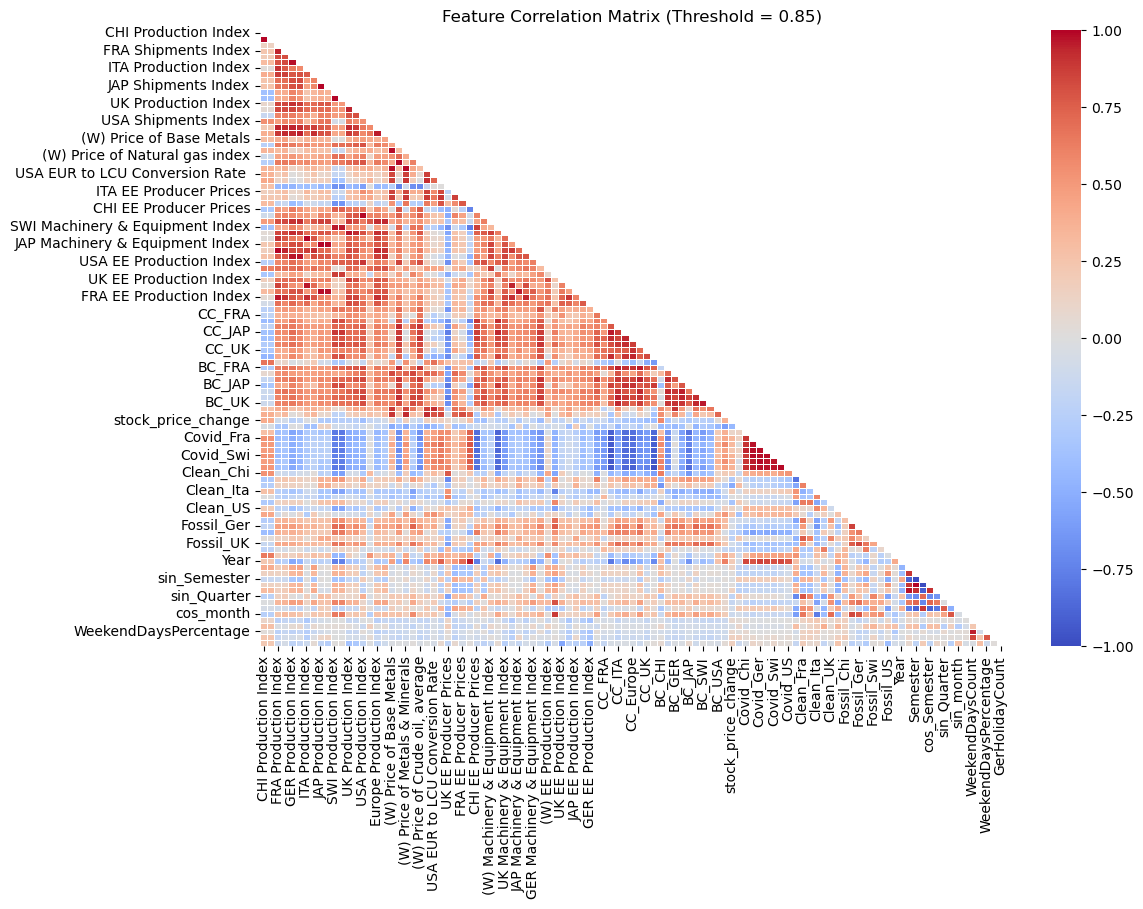

Selected 104 features by RFECV


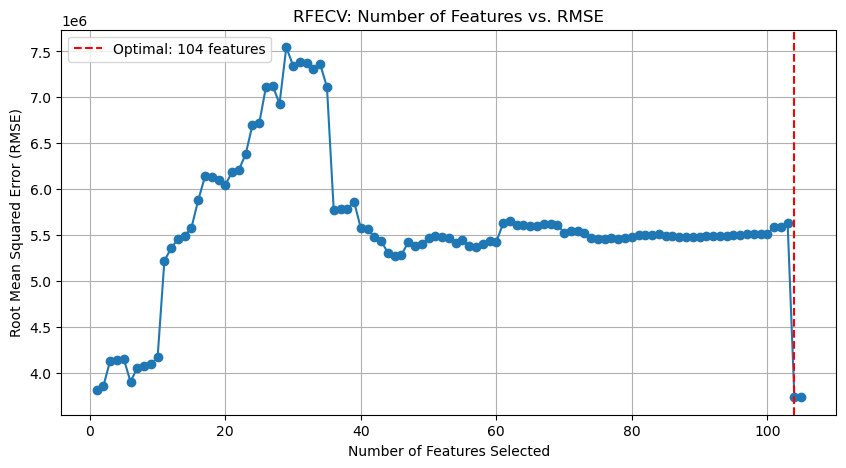

Selected 26 features by importance with threshold 0.009523809523809526


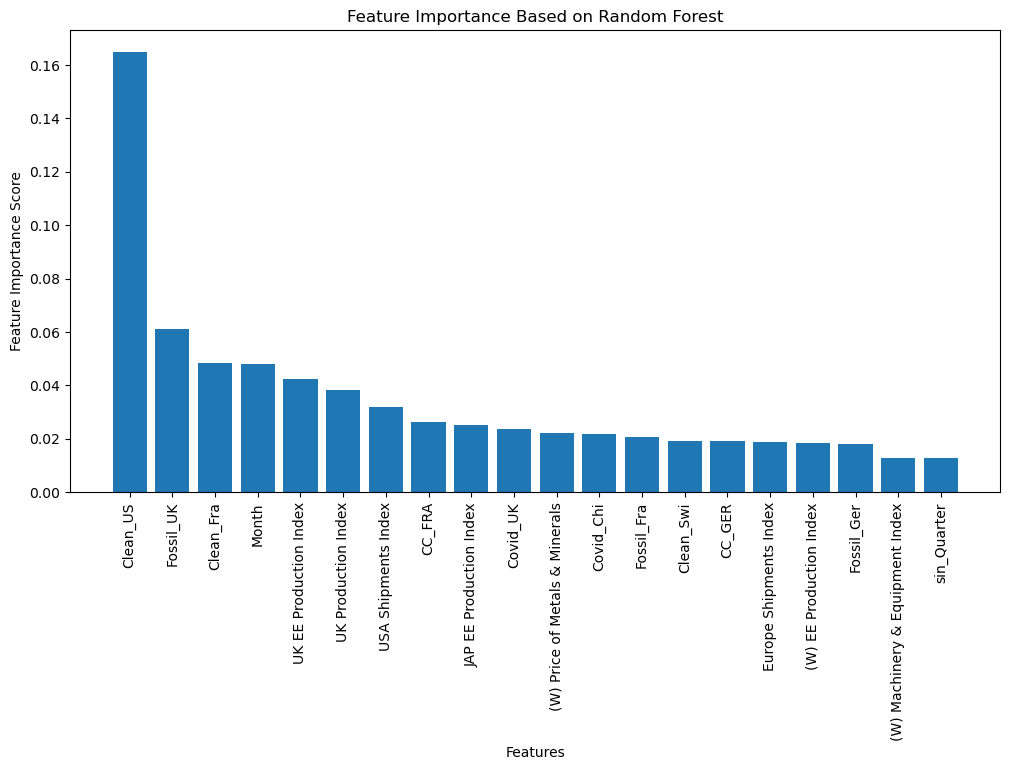

Selected 1 features by Lasso regularization


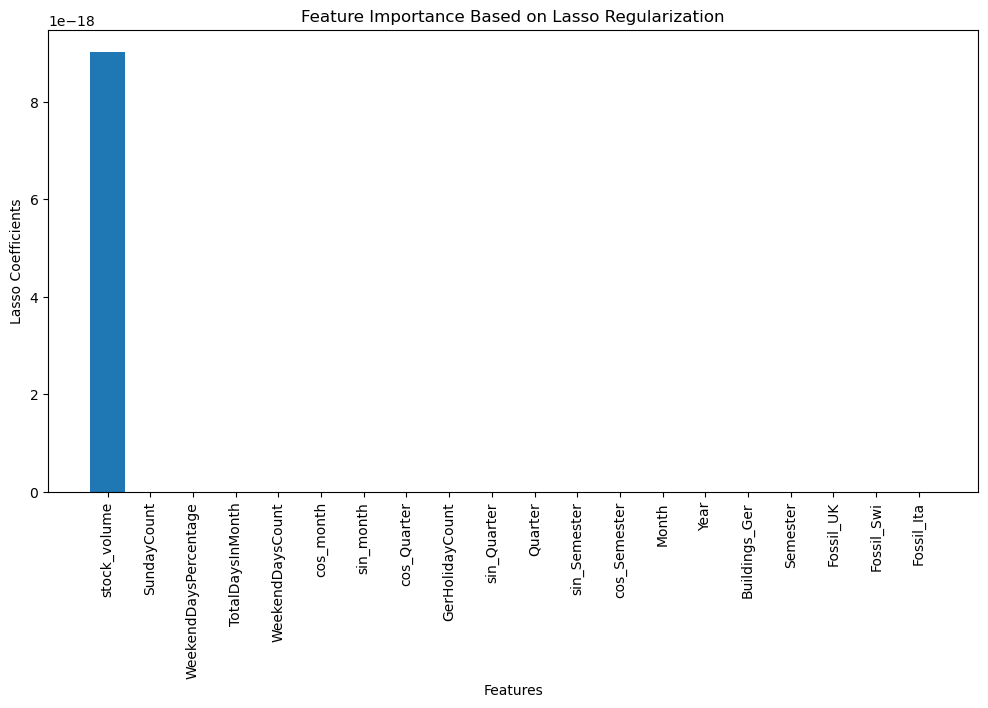

Selected 0 features that intersect across all methods


[]

In [33]:
fs.feature_selection(X_train, y_train_1, method='all', rfe_model=None, 
                      corr_threshold=0.85, importance_threshold='mean', plot=True)

## 2.2 Model Training

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def run_model(model_name, X_train, y_train, X_test=None, y_test=None, params=None):
    """
    Train a model based on the model_name and return the fitted model and predictions.

    Inputs:
        model_name: string, name of the model to be fit ('arima', 'sarima', 'ets', 'xgboost', 'rf')
        X_train, y_train: training data
        X_test, y_test: testing data (optional)
        params: dictionary, hyperparameters for the model (optional)

    Outputs:
        model: fitted model
        y_pred: predictions
    """

    # Default parameters for models that need them
    default_params = {
        'arima': {'order': (1, 1, 1)},
        'sarima': {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 12)},
        'ets': {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 12},
        'xgboost': {},  # XGBoost can be used without parameters
        'rf': {}  # RandomForest can be used without parameters
    }

    # If no params are passed, use the default ones if needed
    if params is None:
        params = default_params.get(model_name, {})

    # Select and train the model
    if model_name == 'arima':
        model = ARIMA(y_train, **params).fit()
        y_pred = model.forecast(steps=len(y_test))
    elif model_name == 'sarima':
        model = SARIMAX(y_train, **params).fit()
        y_pred = model.forecast(steps=len(y_test))
    elif model_name == 'ets':
        model = ExponentialSmoothing(y_train, **params).fit()
        y_pred = model.forecast(steps=len(y_test))
    elif model_name == 'xgboost':
        model = XGBRegressor(**params).fit(X_train, y_train)
        y_pred = model.predict(X_test)
    elif model_name == 'rf':
        model = RandomForestRegressor(**params).fit(X_train, y_train)
        y_pred = model.predict(X_test)
    elif model_name == 'lr':
        model = LinearRegression(**params).fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        raise ValueError(f"Model {model_name} is not supported.")

    return model, y_pred


In [61]:
import numpy as np
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    # Ensure we don't divide by zero
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def modeling(model_names, X_train, y_train, X_val, y_val, params, random_state):
    """
    Inputs:
        model_names: List of model names (e.g., ['xgboost', 'rf'])
        params: Dictionary of parameters for models
        X_train, y_train: Training data
        X_val, y_val: Validation data
        random_state: Random state parameter

    Output: Dictionary with performance metrics for each model
    """
    
    results = {}

    for model_name in model_names:
        print(f"Training model: {model_name}")
        
        # Train the model
        model = run_model(model_name, X_train, y_train, random_state, params.get(model_name, {}))
        
        # Make predictions
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        
        # Calculate RMSE and MAPE
        train_rmse = rmse(y_train, y_train_pred)
        val_rmse = rmse(y_val, y_val_pred)

        train_mape = mape(y_train, y_train_pred)
        val_mape = mape(y_val, y_val_pred)
        
        # Save results
        results[model_name] = {
            'train_rmse': train_rmse,
            'val_rmse': val_rmse,
            'train_mape': train_mape,
            'val_mape': val_mape
        }

        print(f"{model_name} - Train: RMSE: {train_rmse:.4f}, MAPE: {train_mape:.4f}%")
        print(f"{model_name} - Validation: RMSE: {val_rmse:.4f}, MAPE: {val_mape:.4f}%\n")
    
    return results


In [64]:
model_names = ['arima', 'sarima', 'lr']

In [63]:
results, predictions = modeling(model_names, X_train, y_train_1, X_val, y_val_1, params = {}, random_state = 1)

Training model: arima


ValueError: Prediction must have `end` after `start`.

In [47]:
import pandas as pd
import numpy as np
import os
from lazypredict.Supervised import LazyRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.utils import all_estimators

def modelling(X_train, y_train, X_test, y_test, 
              features_used, 
              metric='RMSE', 
              model_choice='arima', 
              save_filename=None):

    save_folder = './modelling_csvs'
    if save_filename is None:
        raise ValueError('Need to name save file')
    else:
        save_path = os.path.join(save_folder, save_filename)

    if model_choice == 'arima':
        if len(features_used) > 1:
            raise ValueError('ARIMA only accepts 1 feature for the target variable.')

        model = ARIMA(y_train, order=(1, 1, 1))
        model_fit = model.fit()

        # Train RMSE (in-sample prediction)
        train_predictions = model_fit.predict(start=0, end=len(y_train)-1, dynamic=False)
        train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))

        # Test RMSE
        predictions = model_fit.forecast(len(y_test))
        val_rmse = np.sqrt(mean_squared_error(y_test, predictions))

        best_model_name = 'ARIMA'
        best_score = val_rmse

        print(f'ARIMA Train RMSE: {train_rmse}')
        print(f'ARIMA Validation RMSE: {val_rmse}')

        
    elif model_choice == 'lazy':
        regressor = LazyRegressor(verbose=0)
        models, _ = regressor.fit(X_train[features_used], X_test[features_used], y_train, y_test)

        best_model_name = models.sort_values(by=metric).iloc[0].name
        
        regressors = dict(all_estimators(type_filter='regressor'))
        model = regressors[best_model_name]()

        model.fit(X_train[features_used], y_train)

        train_preds = model.predict(X_train[features_used])
        test_preds = model.predict(X_test[features_used])

        train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
        val_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

        best_score = val_rmse

        print(f'Best model: {best_model_name}')
        print(f'Train RMSE: {train_rmse}')
        print(f'Validation RMSE: {val_rmse}')

    elif model_choice == 'prophet':
        raise ValueError('NOT WORKING YET')

    result_row = {
        'Features Used': ', '.join(features_used),
        'Best Model': best_model_name,
        'Train RMSE': train_rmse,
        'Validation RMSE': val_rmse
    }

    results_df = pd.DataFrame([result_row])
    results_df.to_csv(save_path, mode='a', header=not os.path.isfile(save_path), index=False)

    return best_model_name, train_rmse, val_rmse



In [49]:
best_model_name, best_score_train, best_score_val  = modelling(X_train_scaled, y_train_1, X_val_scaled, y_val_1, 
              features_used=selected_features, 
              metric='RMSE', 
              model_choice='lazy',
              save_filename = 'categ1_new.csv')

100%|████████████████████████████████████████| 42/42 [00:01<00:00, 29.55it/s]


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 31, number of used features: 0
[LightGBM] [Info] Start training from score 36294712.838710
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet t

In [46]:
from prophet import Prophet
import pandas as pd
from sklearn.metrics import mean_squared_error

def prophet_forecast(X_train, y_train, features_used, periods=10, freq='MS'):
    """
    Function to perform forecasting using Prophet for each feature in 'features_used'.

    Parameters:
    - X_train: DataFrame containing the training data
    - y_train: Actual ground truth values for RMSE calculation (training data)
    - features_used: List of features/columns to forecast using Prophet
    - periods: Number of future periods to predict (default=10)
    - freq: Frequency of the periods (default='MS' for monthly start)

    Returns:
    - best_model_name: Name of the best model ('prophet')
    - best_score: The lowest RMSE score for the model
    """
    best_score = float('inf')
    best_model_name = None

    # Initialize an empty DataFrame to hold future feature values
    future_features = pd.DataFrame()

    # Iterate through each column in 'features_used'
    for column in features_used:
        # Isolate the current column into a new DataFrame 'df1'
        df1 = X_train[[column]].copy()

        # Reset the index of 'df1' and rename columns to fit Prophet's expected format
        data = (df1.reset_index()
                .rename(columns={'index': 'ds', f'{column}': 'y'}))

        # Initialize Prophet model
        model = Prophet()

        # Fit the model to the data
        model.fit(data)

        # Create a DataFrame representing future dates to make predictions
        future = model.make_future_dataframe(periods=periods, freq=freq)

        # Forecast future dates
        forecast_index = model.predict(future)

        # Select relevant columns ('ds' for date, 'yhat' for predictions)
        forecast_index = forecast_index[['ds', 'yhat']]

        # Set the date column as the index
        forecast_index = forecast_index.set_index('ds')

        # Add the forecasted values to the 'future_features' DataFrame
        future_features[column] = forecast_index['yhat'].values

    # Reset the index of the future_features DataFrame to use 'ds' as a regular column
    future_features.reset_index(inplace=True)

    # Add the date column to 'future_features'
    future_features['ds'] = forecast_index.index.values

    # Set 'ds' as the index of 'future_features'
    future_features.set_index('ds', inplace=True)

    # Ensure we only compare the forecasted values against a valid subset of y_train
    # For simplicity, we will compare the mean of the forecasted values to the corresponding `y_train` values
    predicted_values = future_features[features_used].mean(axis=1)  # For simplicity, take the mean of all predictions

    rmse = mean_squared_error(y_train, predicted_values)

    # Compare RMSE to get the best model
    if rmse < best_score:
        best_score = rmse
        best_model_name = 'prophet'

    return best_model_name, best_score


In [47]:
prophet_forecast(X_train_1_scaled, y_train_1, selected_features) 

11:44:03 - cmdstanpy - INFO - Chain [1] start processing
11:44:03 - cmdstanpy - INFO - Chain [1] done processing
11:44:03 - cmdstanpy - INFO - Chain [1] start processing
11:44:03 - cmdstanpy - INFO - Chain [1] done processing


ValueError: Found input variables with inconsistent numbers of samples: [31, 41]

In [34]:
!pip install statsmodels

  Using cached statsmodels-0.14.4-cp313-cp313-macosx_10_13_x86_64.whl.metadata (9.2 kB)
  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
Using cached statsmodels-0.14.4-cp313-cp313-macosx_10_13_x86_64.whl (10.2 MB)
Using cached patsy-1.0.1-py2.py3-none-any.whl (232 kB)


In [42]:
X_train_1_selected = X_train_1_scaled[selected_features]
X_val_1_selected = X_val_1_scaled[selected_features]

best_model_name, best_score = modelling(
    X_train_1_selected, y_train_1, X_val_1_selected, y_val_1, 
    features_used=selected_features, metric='RMSE'
)

100%|██████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 34.63it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 31, number of used features: 0
[LightGBM] [Info] Start training from score 36289610.258065
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet t

In [67]:
# import lazypredict
# from lazypredict.Supervised import LazyRegressor
# from sklearn.metrics import mean_squared_error
# import numpy as np

# def lazy_regressor(X_train, y_train, X_test, y_test, metric='RMSE'):
    
#     # Initialize LazyRegressor
#     regressor = LazyRegressor(verbose=0)
    
#     # Fit the model
#     models, predictions = regressor.fit(X_train, X_test, y_train, y_test)
    
#     # Select the best model based on the metric (e.g., RMSE)
#     best_model = models.sort_values(by=metric).iloc[0]
    
#     # Get the model name and the best score
#     best_model_name = best_model.name
#     best_score = best_model[metric]
    
#     print(f'Best model: {best_model_name}')
#     print(f'{metric} of the best model: {best_score}')
    
#     # Return the best model and score
#     return best_model_name, best_score


In [68]:
# best_model_name, best_score = lazy_regressor(X_train_1_scaled, y_train_1,
#                                              X_val_1_scaled, y_val_1,
#                                              metric='RMSE')


100%|████████████████████████████████████| 42/42 [00:02<00:00, 17.66it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 31, number of used features: 0
[LightGBM] [Info] Start training from score 36289610.258065
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet t

In [43]:
file = pd.read_csv('./lazy_regressor_results.csv')
file

,Features Used,Best Model,RMSE
0,"(W) Price of Base Metals, GER Production Index...",SVR,2887703.96
1,USA Shipments Index_Rolling_Mean_3,HuberRegressor,2823366.38
2,"BC_CHI, USA Shipments Index_Rolling_Mean_3, CH...",HuberRegressor,2830173.62
3,"(W) Price of Base Metals, GER Production Index...",SVR,2887703.92
4,"(W) Price of Natural gas index, USA Production...",SVR,2887703.88


In [75]:
from autosklearn.experimental.askl2 import ForecasterAutoregMultiSeries
from sklearn.metrics import mean_squared_error
import numpy as np

def time_series_forecasting(X_train, y_train, X_test, y_test, 
                            forecast_steps=10, metric='neg_root_mean_squared_error'):

    # Initialize ForecasterAutoregMultiSeries
    forecaster = ForecasterAutoregMultiSeries(steps=forecast_steps, metric=metric)
    
    # Fit the forecaster with training data
    forecaster.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = forecaster.predict(X_test)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'Test RMSE: {rmse}')
    
    return forecaster, y_pred, rmse


ModuleNotFoundError: No module named 'autosklearn'

## Model

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)

# Fit the model using the training data
model.fit(X_train_1_scaled, y_train_1)

# Make predictions on the validation set
y_pred_val_1 = model.predict(X_val_1_scaled)

# Calculate RMSE for the validation set
rmse_val_1 = np.sqrt(mean_squared_error(y_val_1, y_pred_val_1))
print(f'Root Mean Squared Error on Validation Set: {rmse_val_1}')

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(y_val_1.index, y_val_1, label='Actual Validation Values', linestyle='-', color='g')
plt.plot(y_val_1.index, y_pred_val_1, label='Predicted Validation Values', linestyle='--', color='g')

plt.plot(y_train_1.index, y_train_1, label='Actual Training Values', linestyle='-', color='b')

plt.xlabel('Date/Time')
plt.ylabel('Sales')
plt.title('XGBoost Forecasting: Actual vs Predicted (Training and Validation)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
